In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
from keras.models import model_from_json
from keras.optimizers import RMSprop
from mask_utils import get_images, get_input_prediction_tiles, image_from_tiles, \
                       image_generator, get_score_mask_images

Using TensorFlow backend.
/home/rallen/anaconda3/envs/dl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Load the model & weights that were most-recently created by train_mask_model.py.

In [2]:
model_file   = 'data/results/model_180106.json'
weights_file = 'data/results/mask_weights_180106_143329.h5'

with open(model_file,"r") as f:
    json_string = f.read()
model = model_from_json(json_string)
model.load_weights(weights_file)
# compile the model for evaluate()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(1e-3),
              metrics=["accuracy"])

Create a set of images to check vs. the model.

In [3]:
#train_score_images, train_mask_images = get_score_mask_images('data/train')
valid_score_images, valid_mask_images = get_score_mask_images('data/valid')
test_score_images, test_mask_images = get_score_mask_images('data/valid')
#num_train_images,rows,cols,channels = train_score_images.shape
num_valid_images,rows,cols,channels  = valid_score_images.shape
num_test_images,_,_,_ = test_score_images.shape
batch_size = 32
#train_generator = image_generator(train_score_images, train_mask_images,
#                                  batch_size, channels)
valid_generator = image_generator(valid_score_images, valid_mask_images,
                                  batch_size, channels)
test_generator = image_generator(test_score_images, test_mask_images,
                                  batch_size, channels)

Evaluate the compiled model vs the validation & test sets. 
The validation score should match what you saw in the output of your training log.

In [4]:
# does this match your expectation?
model.evaluate_generator(valid_generator,steps=num_valid_images//batch_size)

[0.0054161039391352282, 0.99938731039724038]

In [5]:
# here are some images that were never seen by the model before.
# we hope they get a score similar to the validation set.
model.evaluate_generator(test_generator,steps=num_test_images//batch_size)

[0.0054161039090925645, 0.99938731039724038]

Now loop through the test cases, predicting the images and storing them as mask png files.

In [6]:
#for base_name in ['chromatic','chromatic_piano','gen_one','gen_two','twinkle']:
mask_images = {}
pred_images = {}
for base_name in ['chromatic','gen_one','gen_two','twinkle']:
    print(f"predicting {base_name}")
    score_image, mask_images[base_name] = get_images(base_name)
    input_tiles = get_input_prediction_tiles(score_image)
    pred_tiles = model.predict(input_tiles)
    pred_images[base_name] = image_from_tiles(score_image.width, score_image.height, 
                                             input_tiles.shape[0], pred_tiles, 1)
    with open(f"data/results/pred_mask_{base_name}.png",'wb') as f:
        pred_images[base_name].save(f)

predicting chromatic
predicting gen_one
predicting gen_two
predicting twinkle


Compare the predicted vs. expected images... You'll probably want to do this outside of Jupyter notebook...

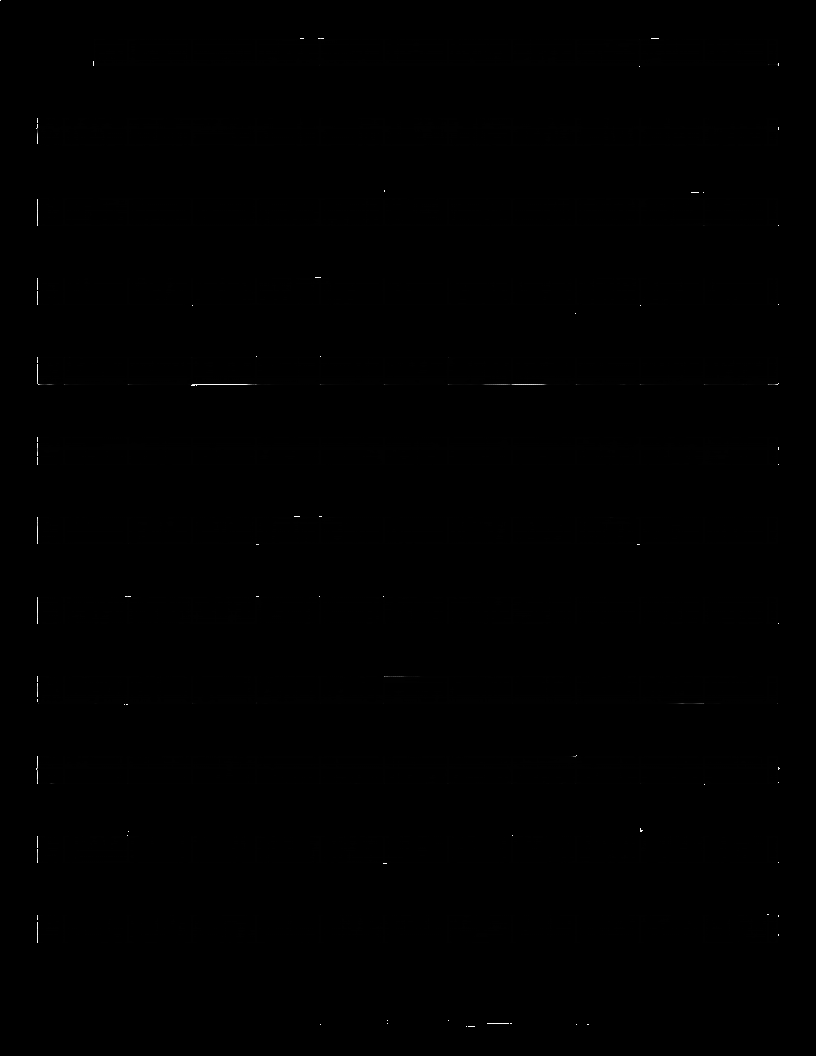

In [8]:
# pred_images size is "rounded up" by grid size
base = 'gen_two'
w, h = mask_images[base].width, mask_images[base].height
diff_ary = np.abs(np.asarray(mask_images[base]) - np.asarray(pred_images[base].crop((0,0,w,h))))
diff_ary[0][0] = 255 # to make sure display scale is right, put 255 in (0,0)
Image.fromarray(diff_ary,'L')
#pred_images[base]
#mask_images[base]